# Investigating well position effect: Scenario 3
**Author:** Jessica Ewald <br>

The purpose of this notebook is to quantify well position effect using two plates with 48X repeated ALK WT and one ALK VAR (a positive control). Previously, classifiers were constructed between cells in each WT versus each VAR well pair, between each possible pair of VAR wells and each possible pair of WT pairs. The WT-WT and VAR-VAR comparisons can be interrogated to get an estimate of well position effect across different positions. The WT-VAR comparisons will give an idea of the size of the morphological perturbation relative to the well position effect. 

In scenario 3, cells were concatenated from both plates before training and testing the model. 

In [14]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
result_dir = pathlib.Path(f'/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/Rep_Ctrls_scen3')
batch = 'Rep_Ctrls_scen3'
feature_sets = ['non_protein', 'protein']

In [16]:
# Read in all F1 score and plot
comparisons = ['REF_control_f1score', 'VAR_control_f1score', 'f1score']
comp_dict = {'REF_control_f1score': 'REF_REF',
             'VAR_control_f1score': 'VAR_VAR',
             'f1score': 'REF_VAR'}

f1_score = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/{batch}_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        f1_score = pl.concat([f1_score, df], how = "vertical")

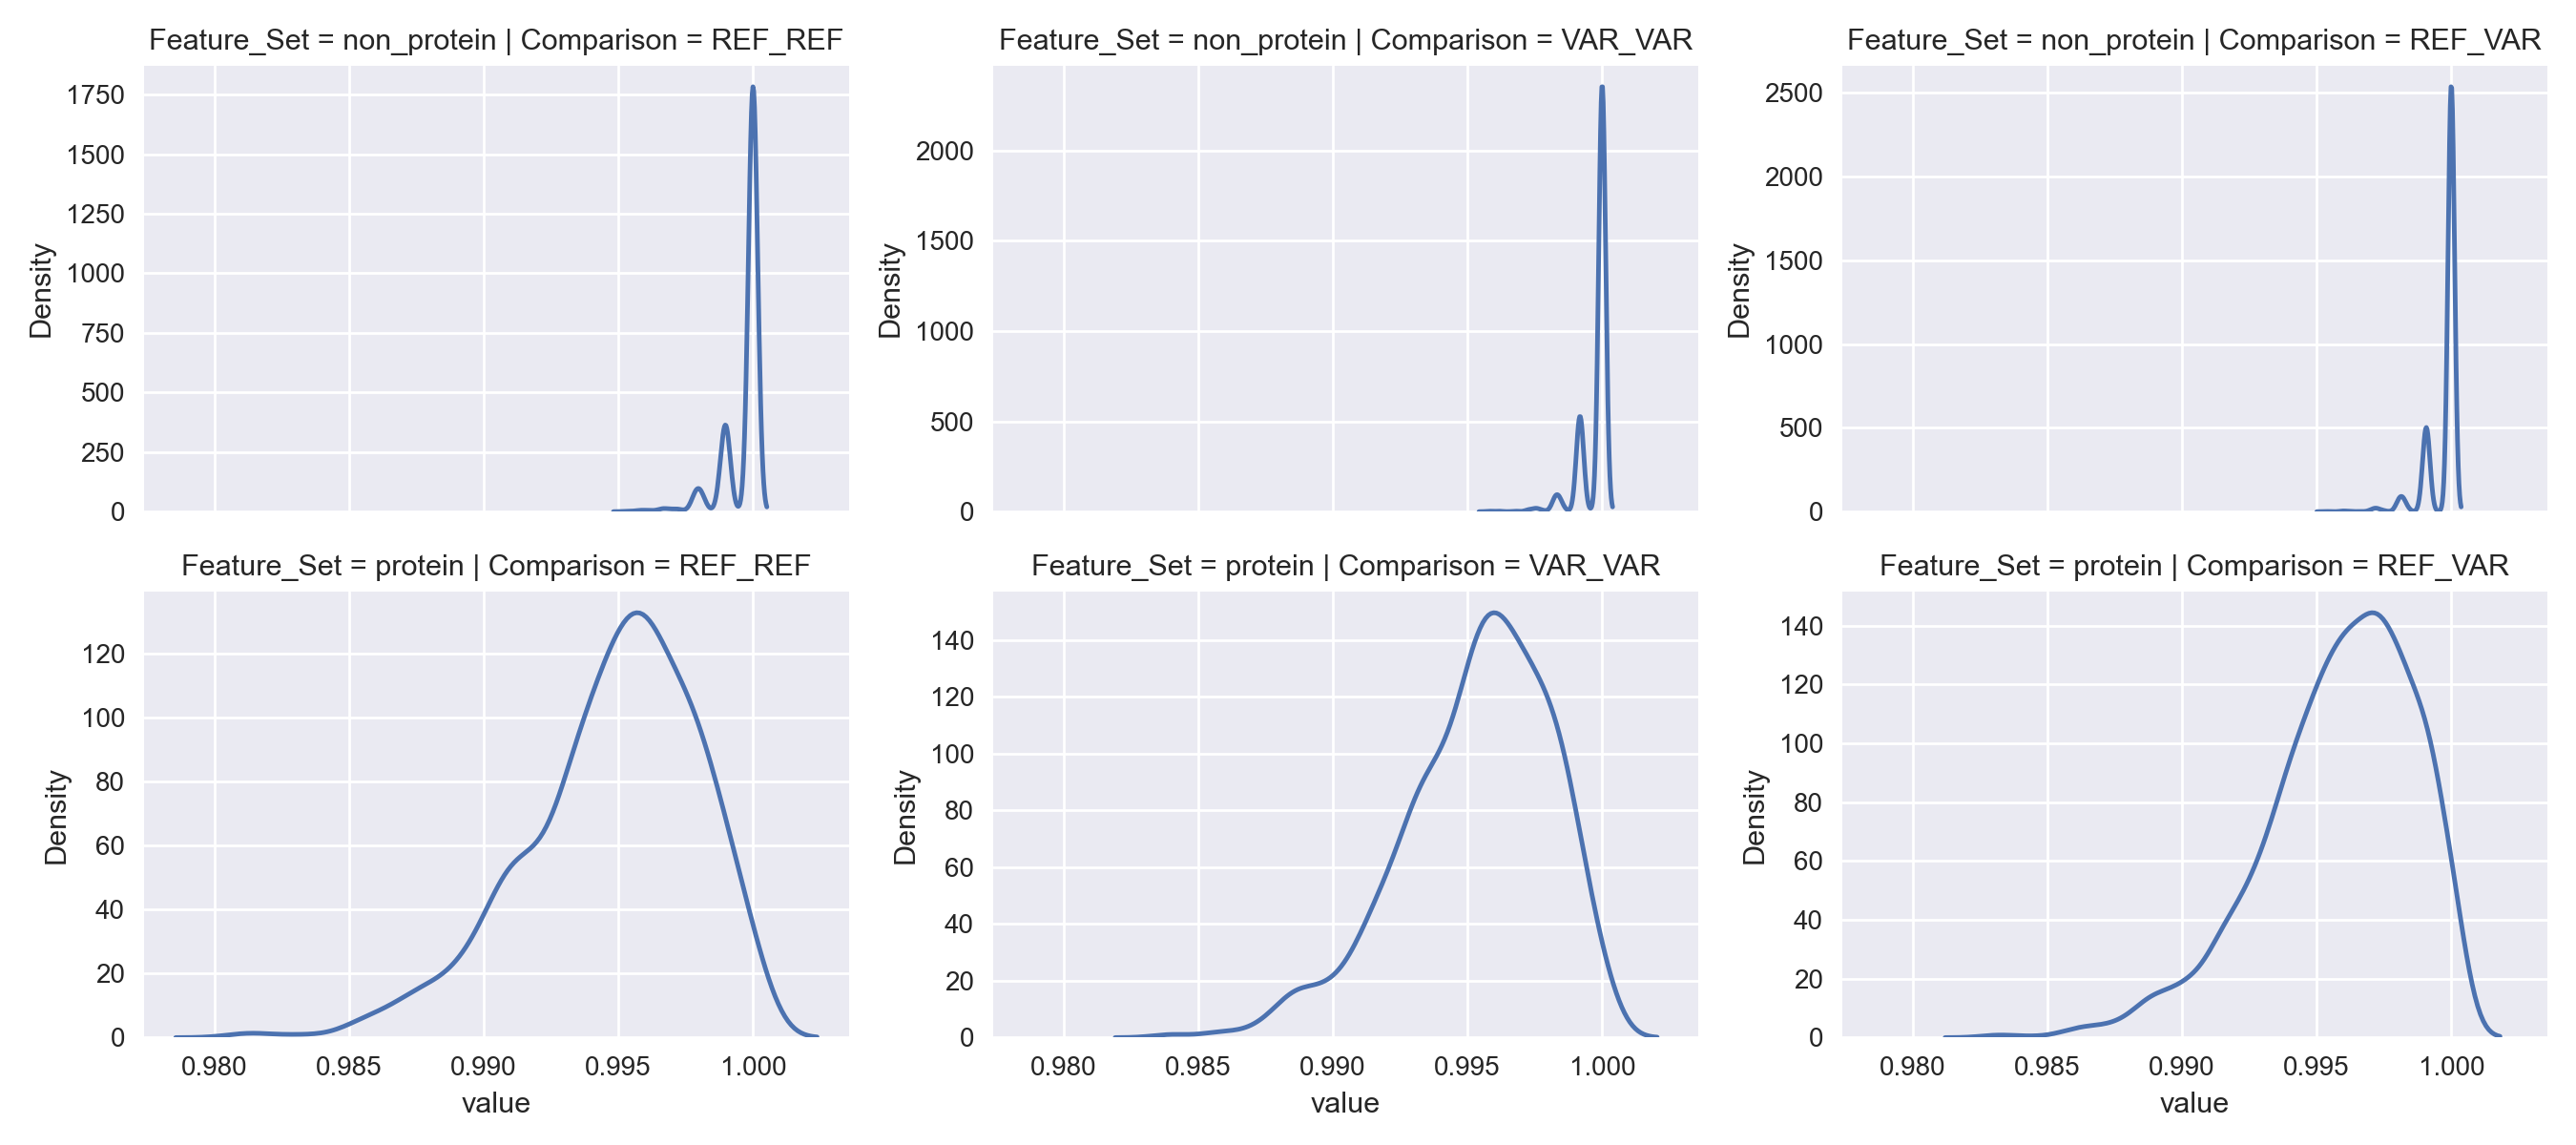

In [31]:
# plot F1 scores, faceted by Feature Set and Comparison

plt.style.use('seaborn')

g = sns.FacetGrid(f1_score.filter(pl.col("variable") == "F1_Score").to_pandas(), row='Feature_Set', col='Comparison', aspect=1.5, sharey=False)
g.map(sns.kdeplot, 'value')

plt.show()

In [5]:
# Read in all variable feature importance scores
comparisons = ['REF_control_feat_importance', 'VAR_control_feat_importance', 'feat_importance']
comp_dict = {'REF_control_feat_importance': 'REF_REF',
             'VAR_control_feat_importance': 'VAR_VAR',
             'feat_importance': 'REF_VAR'}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/{batch}_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        feat_imp = pl.concat([feat_imp, df], how = "vertical")

In [6]:
# Add unique identifier
feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Well_One"), pl.col("Well_Two"), pl.col("Feature_Set"), pl.col("Comparison")], separator="_").alias("ClassifierID"))

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(pl.col("value").rank(descending=True).over("ClassifierID").alias("FIP_rank"))

In [7]:
# summarize ranks

imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(pl.col("FIP_rank").mean().alias("mean_VIP"))

In [8]:
# Do features have similar importance across comparisons?

prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values="mean_VIP")


In [9]:
cor_ref_var = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["VAR_VAR"]].to_series())
cor_ref_diff = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["REF_VAR"]].to_series())
cor_diff_var = stats.pearsonr(prot_summary[["REF_VAR"]].to_series(), prot_summary[["VAR_VAR"]].to_series())

In [10]:
print(cor_ref_var)
print(cor_ref_diff)
print(cor_diff_var)

PearsonRResult(statistic=0.9888788251390062, pvalue=7.254756853602347e-219)
PearsonRResult(statistic=0.9900237445859106, pvalue=5.1508420095677696e-225)
PearsonRResult(statistic=0.9877095991748901, pvalue=3.2740941461431185e-213)


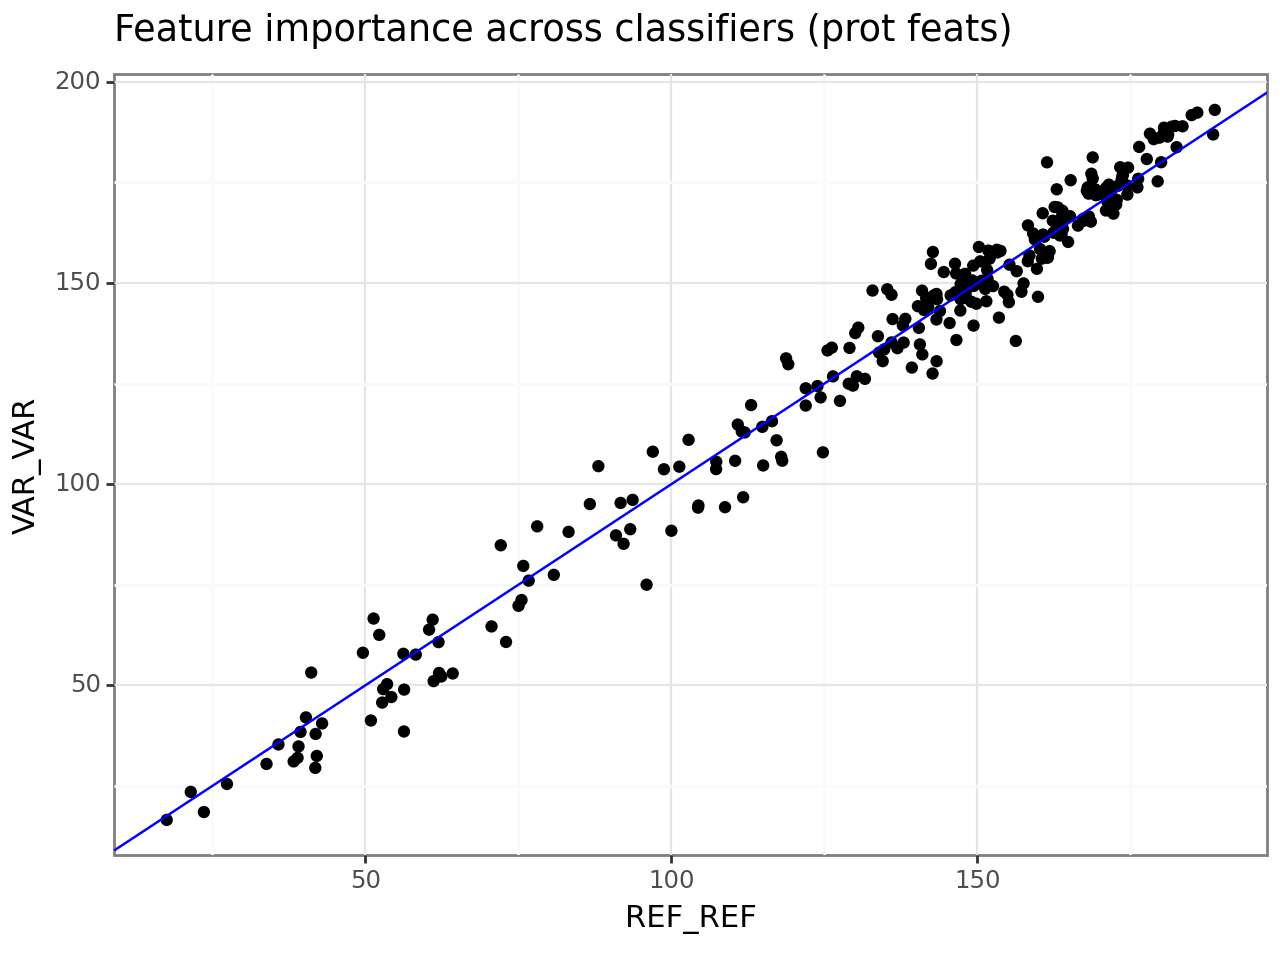

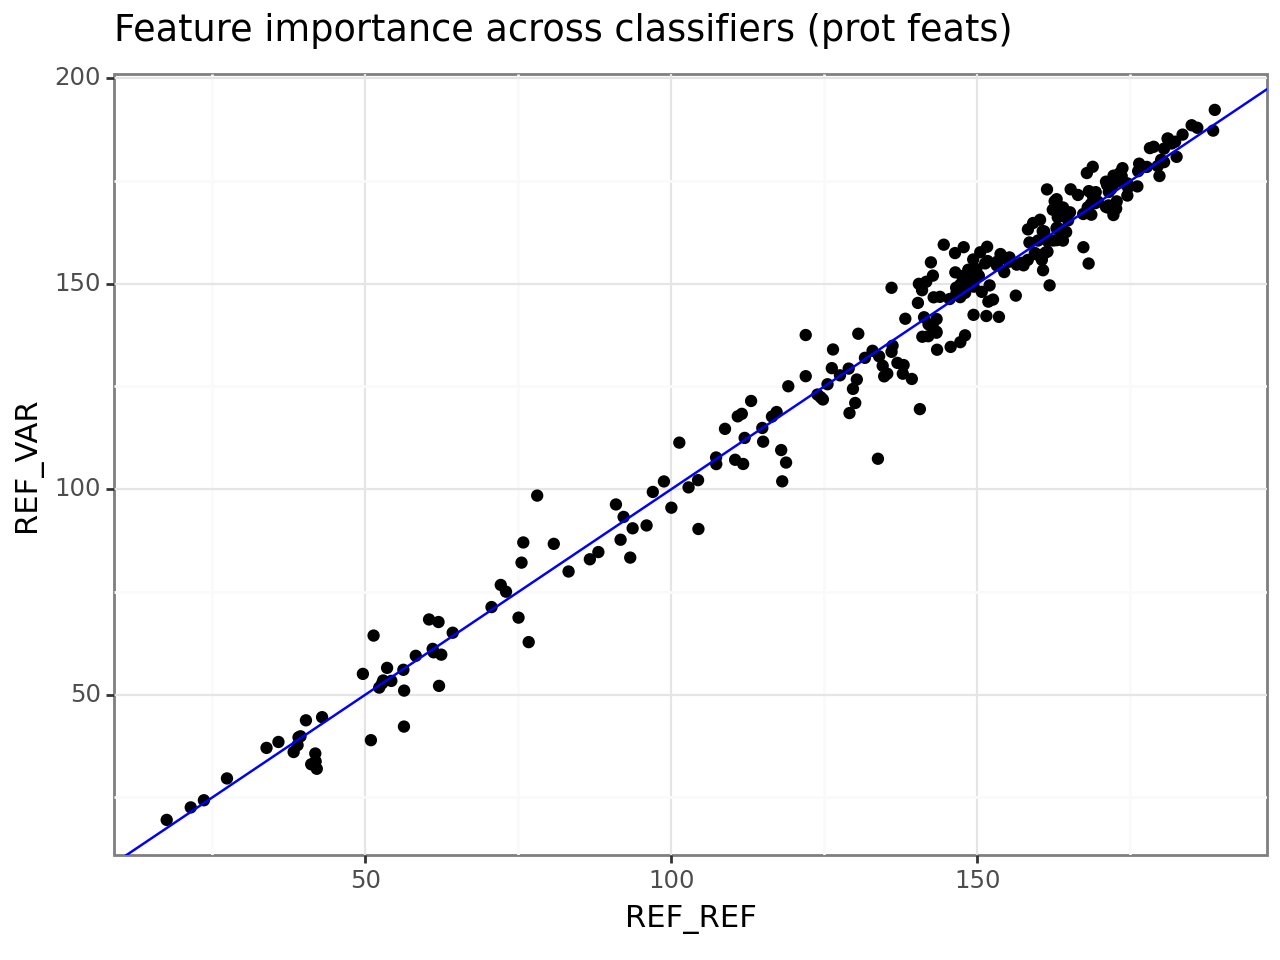

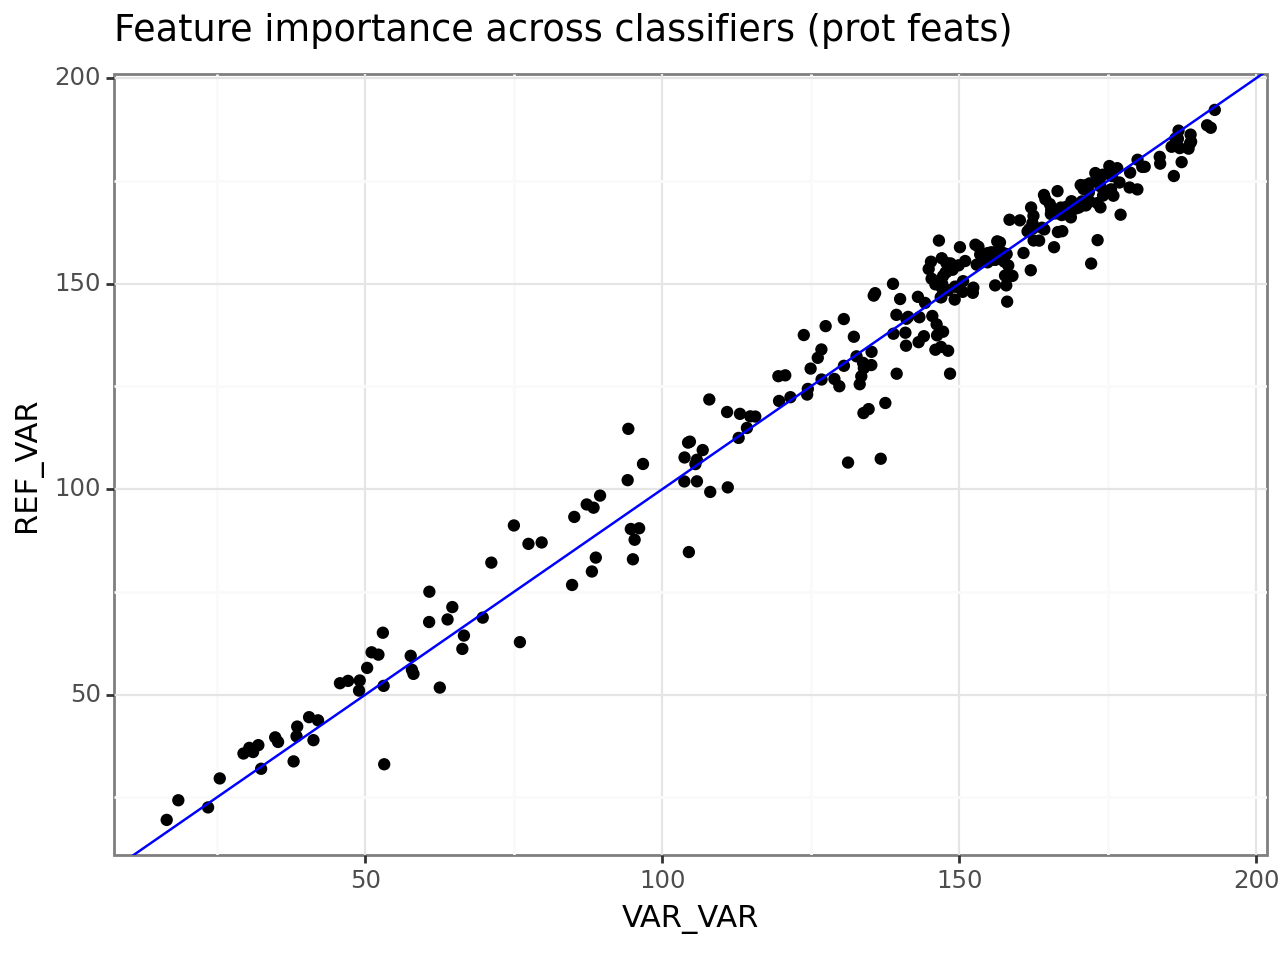

In [11]:
from plotnine import ggplot, aes, geom_point, theme_bw, geom_abline, ggtitle
p1 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "VAR_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p1)

p2 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p2)

p3 = (ggplot(prot_summary)
         + aes(x = "VAR_VAR", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p3)

In [12]:
# Now the same for non-protein features
nonprot_summary = imp_summary.filter(pl.col("Feature_Set") == "non_protein").pivot(index="variable", columns="Comparison", values="mean_VIP")

cor_ref_var = stats.pearsonr(nonprot_summary[["REF_REF"]].to_series(), nonprot_summary[["VAR_VAR"]].to_series())
cor_ref_diff = stats.pearsonr(nonprot_summary[["REF_REF"]].to_series(), nonprot_summary[["REF_VAR"]].to_series())
cor_diff_var = stats.pearsonr(nonprot_summary[["REF_VAR"]].to_series(), nonprot_summary[["VAR_VAR"]].to_series())

print(cor_ref_var)
print(cor_ref_diff)
print(cor_diff_var)


PearsonRResult(statistic=0.9852005689428811, pvalue=0.0)
PearsonRResult(statistic=0.9832155174789969, pvalue=0.0)
PearsonRResult(statistic=0.980452124117601, pvalue=0.0)


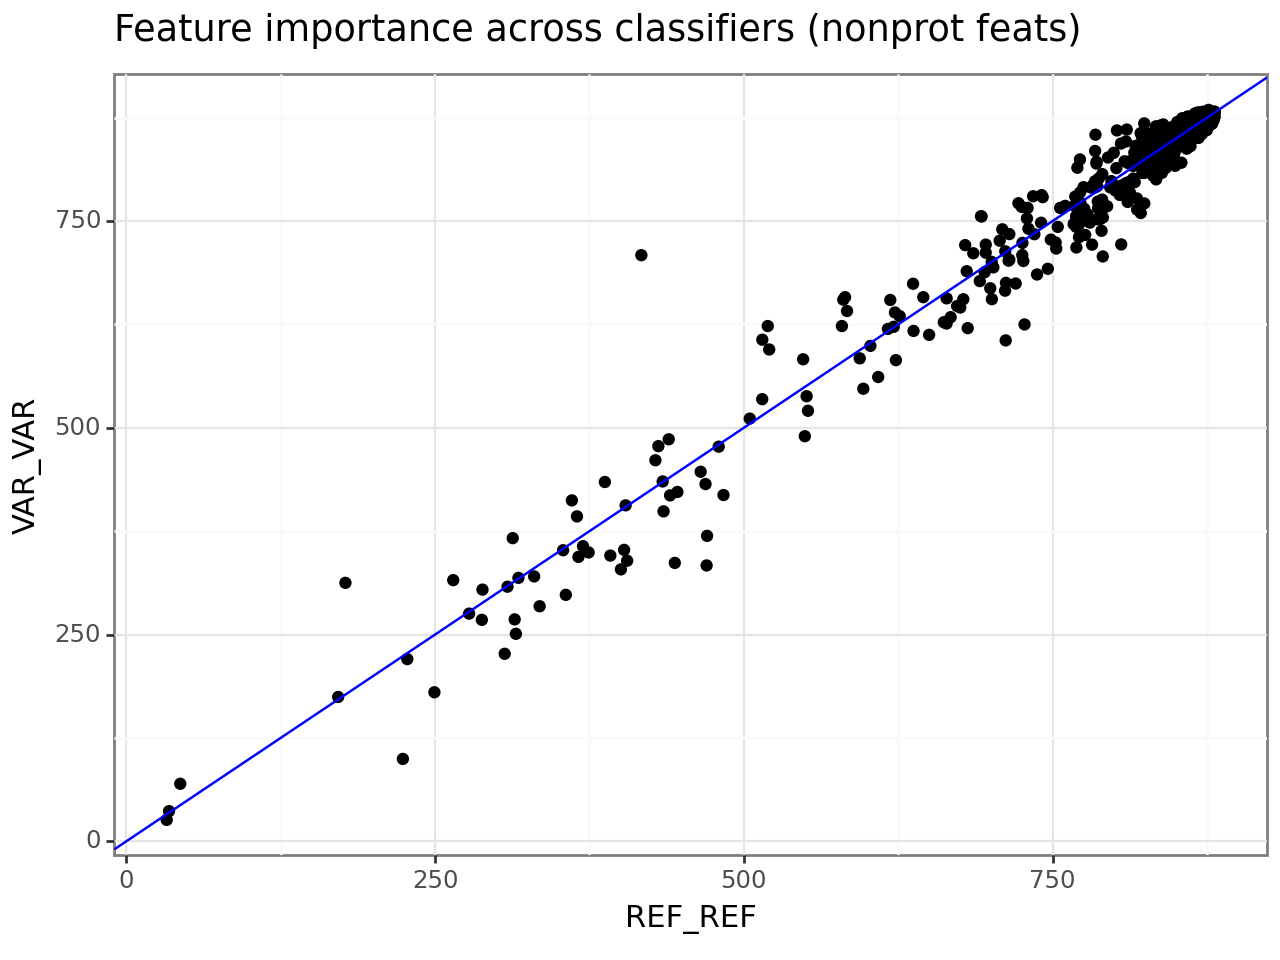

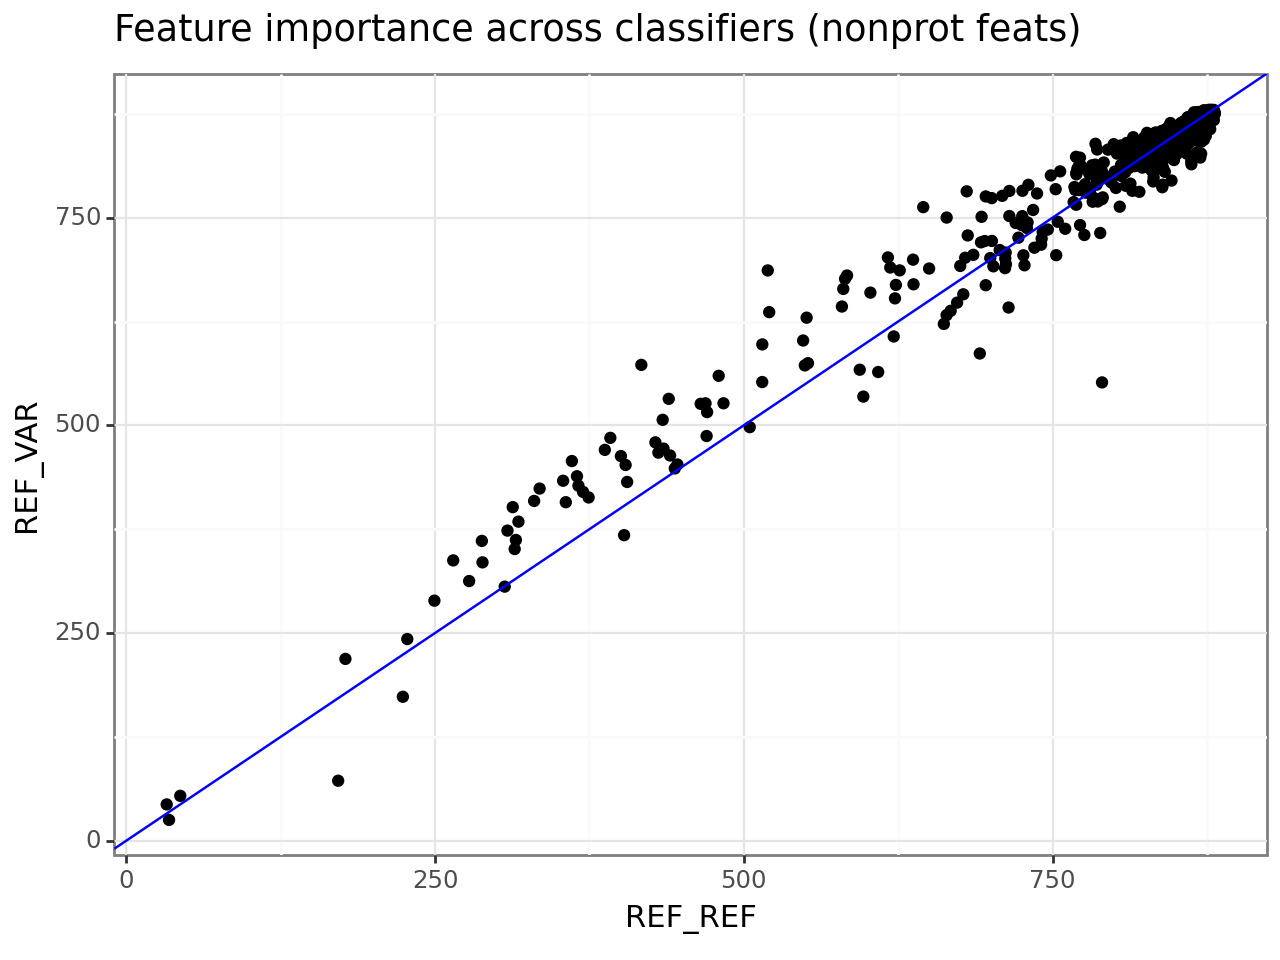

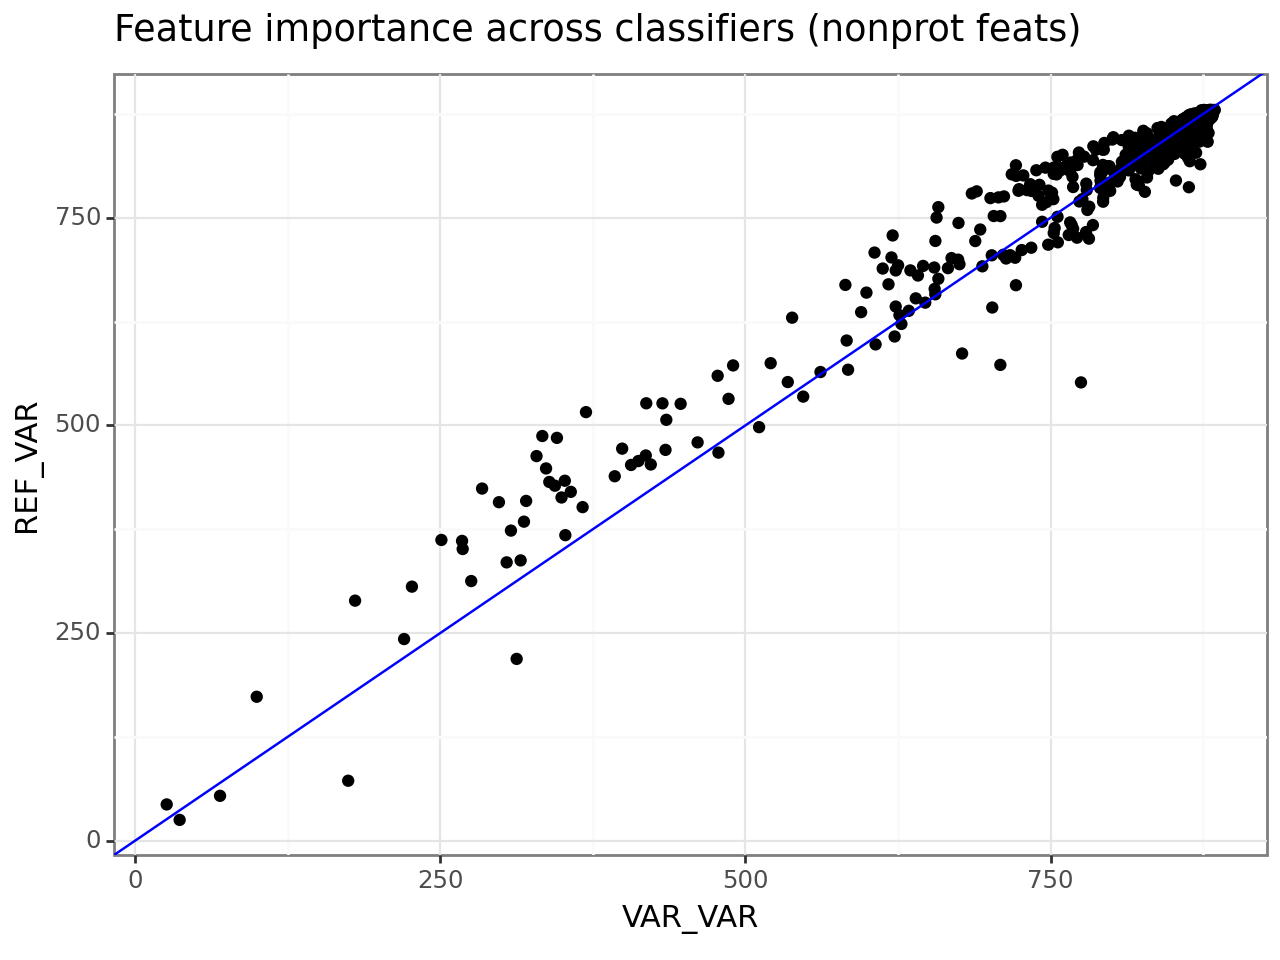

In [13]:
from plotnine import ggplot, aes, geom_point, theme_bw, geom_abline, ggtitle
p1 = (ggplot(nonprot_summary)
         + aes(x = "REF_REF", y = "VAR_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p1)

p2 = (ggplot(nonprot_summary)
         + aes(x = "REF_REF", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p2)

p3 = (ggplot(nonprot_summary)
         + aes(x = "VAR_VAR", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p3)